In [252]:
import time

import pandas as pd
import numpy as np

import matplotlib
%matplotlib inline

from cataclop.ml.pipeline import factories

In [253]:
MAX_HISTORY = 6
NAN_FLAG = 10000.

In [254]:
d = factories.Dataset.factory('default')
d.load(force=True)

In [255]:
pd.concat([pd.DataFrame(d.players.describe()).T, d.players.dtypes], axis=1, sort=True)

,count,mean,std,min,25%,50%,75%,max,0
age,32273.0,4.574164e+00,1.993099e+00,2.0,3.0,4.0,6.0,1.600000e+01,int64
category,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,category
code,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object
condition_age,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,category
condition_sex,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,category
country,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,category
date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object
declared_player_count,32273.0,1.219614e+01,3.048985e+00,3.0,10.0,12.0,15.0,2.000000e+01,int64
distance,32273.0,1.953333e+03,4.894967e+02,800.0,1600.0,2000.0,2300.0,4.100000e+03,int64
earnings,32273.0,6.180678e+06,1.939113e+07,0.0,515000.0,2045000.0,6065000.0,1.471275e+09,int64


In [256]:
df = d.players.groupby('race_id').filter(lambda race: race['race_count'].max() > 0)

races = df.groupby('race_id')

agg_features = ['race_count', 
                'victory_count', 
                'placed_2_count', 
                'placed_3_count',
                'victory_earnings',
                'prev_year_earnings',
                'handicap_distance',
                'handicap_weight'
               ] + ['hist_{}_pos'.format(i+1) for i in range(MAX_HISTORY)]

stats = races[agg_features].agg([np.mean, np.std])
stats.columns = ['_'.join(col) for col in stats.columns.values]

df = df.join(stats, how='left', on='race_id')

for f in agg_features:
    df['{}_r'.format(f)] = df[f] - df['{}_mean'.format(f)] / df['{}_std'.format(f)]
    
agg_features = ['{}_r'.format(f) for f in agg_features] + ['{}_std'.format(f) for f in agg_features] + ['{}_mean'.format(f) for f in agg_features]

df[agg_features] = df[agg_features].replace([np.inf, -np.inf], np.nan)
df[agg_features] = df[agg_features].fillna(NAN_FLAG)


In [257]:
start = time.time()

odds = np.ones([len(df), 20]) * NAN_FLAG
idx = []

races = df.groupby('race_id')

j = 0
for (id, race) in races:
    jj = len(race.index)
    odds_sorted = np.array(sorted(race[race['final_odds_ref']>1.]['final_odds_ref'].values))
    odds[j:j+jj, 0:len(odds_sorted)] = odds_sorted
    
    idx = idx + list(race.index)
    
    j = j + jj
    
    
odds_df = pd.DataFrame(odds, columns=['odds_{:d}'.format(i) for i in range(20)], index=idx)
df = pd.concat([df,odds_df], axis=1)

end = time.time()
print(end - start)

5.495937824249268


In [258]:
df['speed'] = (df['distance'] / df['time']).fillna(NAN_FLAG)
df['final_odds_ref_inv'] = (1. / df['final_odds_ref']).fillna(NAN_FLAG)

df = df.groupby('race_id').filter(lambda r: r['position'].min() == 1)
df = df.groupby('race_id').filter(lambda r: r['final_odds_ref'].min() > 0)
df = df.sort_index()
df_orig = df.copy()

In [259]:
df_test = df_orig[(df_orig['start_at'] > '2017-11-02') & (df_orig['category']=='ATTELE')].copy()
df = df_orig[(df_orig['start_at'] <= '2017-11-01') & (df_orig['category']=='ATTELE')].copy()

df_test = df_test.sort_index()
df = df.sort_index()

In [260]:
pd.concat([pd.DataFrame(df.describe()).T, df.dtypes], axis=1, sort=True)

,count,mean,std,min,25%,50%,75%,max,0
age,4827.0,5.479801e+00,2.164245e+00,2.000000,4.000000e+00,5.000000e+00,7.000000e+00,1.400000e+01,int64
category,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,category
code,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object
condition_age,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,category
condition_sex,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,category
country,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,category
date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object
declared_player_count,4827.0,1.318873e+01,2.625510e+00,6.000000,1.100000e+01,1.400000e+01,1.600000e+01,1.800000e+01,int64
distance,4827.0,2.353452e+03,3.061168e+02,1600.000000,2.100000e+03,2.300000e+03,2.650000e+03,3.150000e+03,int64
earnings,4827.0,7.750493e+06,1.569039e+07,0.000000,1.286300e+06,3.482000e+06,9.396500e+06,4.925731e+08,int64


In [262]:
def random_race(df, cols=None, n=1):

    if cols is None:
        cols = ['position', 'num', 'final_odds', 'final_odds_ref', 'hist_1_pos', 'hist_1_pos_r', 'hist_1_pos_mean', 'hist_1_pos_std', 'odds_0', 'odds_1']

    return df.reset_index().set_index(['race_id', 'id']).loc[np.random.permutation(df['race_id'].unique())[0:n]][cols]
    
random_race(df)

position  num  final_odds  final_odds_ref  hist_1_pos  \
race_id id                                                             
3658    25126       5.0    1        15.5            19.6         0.0   
        25127       NaN    2        23.5            14.3         0.0   
        25128       1.0    3         5.6             5.7         4.0   
        25129       6.0    4        64.0            41.9         0.0   
        25130       3.0    5         5.3             7.3         3.0   
        25131       NaN    6         2.8             2.5         2.0   
        25132       NaN    7        17.2            11.8         0.0   
        25133       2.0    8         4.6             5.1         4.0   
        25134       4.0    9        14.9            20.5         3.0   

               hist_1_pos_r  hist_1_pos_mean  hist_1_pos_std  odds_0  odds_1  
race_id id                                                                    
3658    25126     -0.994672         1.777778        1.787301     2.5     5.1  
        25127     -0.994672         1.777778        1.787301     2.5     5.1  
        25128      3.005328         1.777778        1.787301     2.5     5.1  
        25129     -0.994672         1.777778        1.787301     2.5     5.1  
        25130      2.005328         1.777778        1.787301     2.5     5.1  
        25131      1.005328         1.777778        1.787301     2.5     5.1  
        25132     -0.994672         1.777778        1.787301     2.5     5.1  
        25133      3.005328         1.777778        1.787301     2.5     5.1  
        25134      2.005328         1.777778        1.787301     2.5     5.1

In [263]:
features = agg_features

features = features + ['declared_player_count'] + ['hist_{}_pos'.format(i+1) for i in range(6)]

features = features + ['odds_{:d}'.format(i) for i in range(20)]

features

['race_count_r',
 'victory_count_r',
 'placed_2_count_r',
 'placed_3_count_r',
 'victory_earnings_r',
 'prev_year_earnings_r',
 'handicap_distance_r',
 'handicap_weight_r',
 'hist_1_pos_r',
 'hist_2_pos_r',
 'hist_3_pos_r',
 'hist_4_pos_r',
 'hist_5_pos_r',
 'hist_6_pos_r',
 'race_count_std',
 'victory_count_std',
 'placed_2_count_std',
 'placed_3_count_std',
 'victory_earnings_std',
 'prev_year_earnings_std',
 'handicap_distance_std',
 'handicap_weight_std',
 'hist_1_pos_std',
 'hist_2_pos_std',
 'hist_3_pos_std',
 'hist_4_pos_std',
 'hist_5_pos_std',
 'hist_6_pos_std',
 'race_count_mean',
 'victory_count_mean',
 'placed_2_count_mean',
 'placed_3_count_mean',
 'victory_earnings_mean',
 'prev_year_earnings_mean',
 'handicap_distance_mean',
 'handicap_weight_mean',
 'hist_1_pos_mean',
 'hist_2_pos_mean',
 'hist_3_pos_mean',
 'hist_4_pos_mean',
 'hist_5_pos_mean',
 'hist_6_pos_mean',
 'declared_player_count',
 'hist_1_pos',
 'hist_2_pos',
 'hist_3_pos',
 'hist_4_pos',
 'hist_5_pos',
 'hi

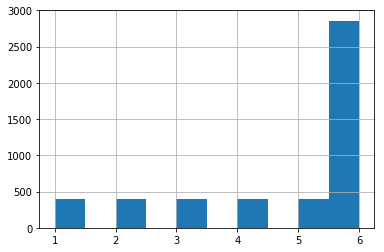

In [288]:

N_TARGETS = 6

df['target'] = df['position'].copy()
df.loc[df['target'] > N_TARGETS, 'target'] = N_TARGETS
df['target'].fillna(N_TARGETS, inplace=True)

df['target'].hist()


In [289]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import log_loss, mean_absolute_error
from sklearn.model_selection import KFold, GroupKFold
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler

groups = df['race_id'].values

group_kfold = GroupKFold(n_splits=3)

splits = list(group_kfold.split(df.values, df['position'].values, groups))

from cataclop.ml import preprocessing

models = [
    {
        'name': 'rf_10',
        'model': RandomForestClassifier(n_estimators=10),
        'scaler': False
    },
    {
        'name': 'rf_30',
        'model': RandomForestClassifier(n_estimators=30),
        'scaler': False
    },
    {
        'name': 'rf_100',
        'model': RandomForestClassifier(n_estimators=100),
        'scaler': False
    },
    {
        'name': 'ada_10',
        'model': AdaBoostClassifier(n_estimators=10),
        'scaler': False
    },
    {
        'name': 'ada_30',
        'model': AdaBoostClassifier(n_estimators=30),
        'scaler': False
    },
    {
        'name': 'ada_100',
        'model': AdaBoostClassifier(n_estimators=100),
        'scaler': False
    },
    {
        'name': 'knn_10',
        'model': KNeighborsClassifier(n_neighbors=10),
        'scaler': False
    },
    {
        'name': 'knn_30',
        'model': KNeighborsClassifier(n_neighbors=30),
        'scaler': False
    },
    {
        'name': 'knn_100',
        'model': KNeighborsClassifier(n_neighbors=100),
        'scaler': False
    }
]

for model in models:
    for i in range(N_TARGETS):
        df['pred_{}_{}'.format(model['name'], i+1)] = 0.0
        df_test['pred_{}_{}'.format(model['name'], i+1)] = 0.0

for train_index, test_index in splits:
    
    for model in models:

        X_train = df[features].iloc[train_index].copy()
        y_train = df['target'].iloc[train_index]

        dummies = preprocessing.get_dummies(df.iloc[train_index], ['sub_category'])
        X_train = pd.concat([X_train, preprocessing.get_dummy_values(df.iloc[train_index], dummies)], axis=1)
        
        X_train = X_train[df.iloc[train_index]['final_odds_ref'] < 20]
        y_train = df['target'].iloc[train_index][df.iloc[train_index]['final_odds_ref'] < 20]

        X_test = df[features].iloc[test_index].copy()
        y_test = df['target'].iloc[test_index]
    
        X_val = df_test[features].copy()

        X_test = pd.concat([X_test, preprocessing.get_dummy_values(df.iloc[test_index], dummies)], axis=1)
        X_val = pd.concat([X_val, preprocessing.get_dummy_values(df_test, dummies)], axis=1)

        X_train = X_train.values
        X_test = X_test.values
        X_val = X_val.values

        idx = df.iloc[test_index].index

        if model['scaler']:
            scaler = StandardScaler()
            scaler.fit(X_train)

            X_train = scaler.transform(X_train)
            X_test = scaler.transform(X_test)
            X_val = scaler.transform(X_val)

        clf = model['model']
        clf.fit(X_train, y_train.values)

        p = clf.predict_proba(X_test)
    
        print( model['name'], log_loss(y_test.values, p) )

        for i in range(N_TARGETS):
            df.loc[idx, 'pred_{}_{}'.format(model['name'], i+1)] = p[:, list(clf.classes_).index(i+1)]

        p = clf.predict_proba(X_val)
    
        for i in range(N_TARGETS):
            df_test['pred_{}_{}'.format(model['name'], i+1)] = p[:, list(clf.classes_).index(i+1)]

    
    
    
    

rf_10 5.554127049441543
rf_30 1.9265270174918743
rf_100 1.4237408360286394
ada_10 1.7477517736725083
ada_30 1.7609378423137725
ada_100 1.7748948421001927
knn_10 5.219560945257528
knn_30 1.780809566814482
knn_100 1.372952595083455
rf_10 5.586327236970818
rf_30 1.9383892168976393
rf_100 1.4038046590122282
ada_10 1.7250699510682035
ada_30 1.7621452884588367
ada_100 1.7751941933993942
knn_10 5.095700545821772
knn_30 1.8278020335576974
knn_100 1.3769961847434817
rf_10 5.910594074805802
rf_30 2.0380703552533608
rf_100 1.4115142623028891
ada_10 1.7482085271430141
ada_30 1.7665285976752414
ada_100 1.7740729599077572
knn_10 5.414226982152705
knn_30 1.623483488406952
knn_100 1.3796451221187505


In [290]:
random_race(df, ['final_odds', 'position'] + ['pred_{}_1'.format(model['name']) for model in models])

final_odds  position  pred_rf_10_1  pred_rf_30_1  pred_rf_100_1  \
race_id id                                                                      
858     5930       142.7      10.0           0.3      0.133333           0.23   
        5931       117.0       9.0           0.1      0.200000           0.17   
        5932        18.2       7.0           0.2      0.233333           0.24   
        5933         2.6       1.0           0.3      0.400000           0.27   
        5934        14.4       4.0           0.2      0.133333           0.21   
        5935        10.2       3.0           0.2      0.266667           0.20   
        5936        88.7       8.0           0.5      0.233333           0.25   
        5937         2.4       5.0           0.4      0.300000           0.36   
        5938         7.2       2.0           0.5      0.233333           0.34   
        5939       121.7       6.0           0.1      0.133333           0.21   

              pred_ada_10_1  pred_ada_30_1  pred_ada_100_1  pred_knn_10_1  \
race_id id                                                                  
858     5930       0.171280       0.170942        0.168744            0.0   
        5931       0.171280       0.168866        0.166305            0.0   
        5932       0.171280       0.170794        0.166618            0.1   
        5933       0.171280       0.170942        0.168241            0.1   
        5934       0.164545       0.166934        0.167040            0.1   
        5935       0.171280       0.168726        0.168598            0.3   
        5936       0.164545       0.165879        0.168043            0.3   
        5937       0.164545       0.166600        0.167571            0.3   
        5938       0.164545       0.164980        0.165280            0.2   
        5939       0.171850       0.171147        0.168305            0.3   

              pred_knn_30_1  pred_knn_100_1  
race_id id                                   
858     5930       0.066667            0.10  
        5931       0.033333            0.11  
        5932       0.066667            0.11  
        5933       0.066667            0.13  
        5934       0.033333            0.16  
        5935       0.233333            0.16  
        5936       0.200000            0.16  
        5937       0.166667            0.17  
        5938       0.166667            0.13  
        5939       0.166667            0.17

In [268]:
clf = models[2]['model']
fi = pd.Series(clf.feature_importances_, index=features+preprocessing.get_dummy_features(dummies))
print(fi.sort_values(ascending=False))

hist_1_pos_r                                           0.041752
hist_2_pos_r                                           0.040266
hist_4_pos_r                                           0.039150
hist_3_pos_r                                           0.038430
victory_earnings_r                                     0.038071
hist_5_pos_r                                           0.035277
race_count_r                                           0.033629
hist_6_pos_r                                           0.033357
prev_year_earnings_r                                   0.031497
victory_count_r                                        0.031356
placed_2_count_r                                       0.030945
placed_3_count_r                                       0.029749
hist_1_pos                                             0.027597
hist_3_pos                                             0.027017
hist_2_pos                                             0.026665
hist_4_pos                              

In [7]:
from gplearn.genetic import SymbolicTransformer

function_set = ['add', 'sub', 'mul', 'div',
                'sqrt', 'log', 'abs', 'neg', 'inv',
                'max', 'min']

N_GP_FEATURES = 10

for i in range(N_GP_FEATURES):
    df['gp_feat_{}'.format(i+1)] = 0.
    df_test['gp_feat_{}'.format(i+1)] = 0.
    
df_test['target'] = df_test['position'].copy()
df_test.loc[df_test['target'] > N_TARGETS, 'target'] = N_TARGETS-1
df_test['target'].fillna(N_TARGETS, inplace=True)


X_train = df_test[features].copy()
y_train = df_test['target']

X_test = df[features].copy()
y_test = df['target']

X_train = X_train.values
X_test = X_test.values

gp = SymbolicTransformer(generations=10, population_size=2000,
                     hall_of_fame=100, n_components=N_GP_FEATURES,
                     function_set=function_set,
                     parsimony_coefficient=0.0005,
                     max_samples=0.9, verbose=1,
                     random_state=0, n_jobs=3)

gp.fit(X_train, y_train.values)

gp_features = gp.transform(X_test)

for i in range(N_GP_FEATURES):
    df['gp_feat_{}'.format(i+1)] = gp_features[:,i]


    

    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    10.15 0.04150967078789689       12 0.20312161281594351 0.140199928906455     15.09s
   1     6.38 0.09968915062184357        5 0.21686046838397063 0.19825254742974507     18.15s
   2     7.23 0.13025920710052435        5 0.24581152313901466 0.22030686642618857     18.21s
   3     6.55 0.1427080471143653        7 0.25332901096412835 0.1550752489113706     16.17s
   4     7.16 0.15427103255286567       13 0.2564615654608883 0.12166521233221597     13.95s
   5     8.11 0.18358284597336658        9 0.2564818041632414 0.2048215208209793     11.16s
   6     6.93 0.19709534209276922        9 0.25965080952360925 0.18328172589043235      8.27s
   7     6.57 0.20119237602754383        9 0.2605683233227066 0.17829638128287956      5.39s
   8      6

In [155]:
from gplearn.fitness import make_fitness

def _mape(y, y_pred, w):
    """Calculate the mean absolute percentage error."""
    diffs = np.abs(np.divide((np.maximum(0.001, y) - np.maximum(0.001, y_pred)),
                             np.maximum(0.001, y)))
    return 100. * np.average(diffs, weights=w)

mape = make_fitness(_mape, greater_is_better=False)

In [159]:
from gplearn.genetic import SymbolicTransformer, SymbolicRegressor

function_set = ['add', 'sub', 'mul', 'div',
                'sqrt', 'log', 'abs', 'neg', 'inv',
                'max', 'min']

N_GP_FEATURES = 10

for i in range(N_GP_FEATURES):
    df['gp_feat_{}'.format(i+1)] = 0.
    df_test['gp_feat_{}'.format(i+1)] = 0.
    
df_test['target'] = df_test['position'].copy()
df_test.loc[df_test['target'] > N_TARGETS, 'target'] = N_TARGETS-1
df_test['target'].fillna(N_TARGETS, inplace=True)

df_test['target'] = np.log(df_test['target'])


X_train = df_test[features].copy()
y_train = df_test['target']

X_test = df[features].copy()
y_test = df['target']

X_train = X_train.values
X_test = X_test.values

gp = SymbolicRegressor(verbose=1, metric=mape, function_set=function_set, generations=10, population_size=2000)

gp.fit(X_train, y_train.values)

gp_features = gp.predict(X_test)

df['gp_pred'] = gp_features


    

    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    10.76 949588591422.9965        6 0.3927415770367845              N/A      8.23s
   1     8.74 3557126.2158477446        4 0.3146995104725227              N/A     15.18s
   2    10.27 1542391.0098858587       22 0.31264450868041327              N/A     16.50s
   3     9.89 4965.212713132404       13 0.30737757472359634              N/A     16.84s
   4      8.4 149.39441989589926       14 0.30737757472359634              N/A     13.80s
   5     6.23 22.24059754543769       17 0.30737757472359634              N/A     10.74s
   6     4.52 8.00691440881688       12 0.3054100838207342              N/A      7.44s
   7     6.13 9.319282217122785       17 0.3053942090245155              N/A      4.72s
   8     8.83 50.7931152489485       17 0.305

In [270]:

stacked_features = ['declared_player_count', 'victory_earnings_std', 'handicap_weight_std', 'prev_year_earnings_std'] + ['hist_{}_pos_mean'.format(i+1) for i in range(3)] + ['hist_{}_pos_std'.format(i+1) for i in range(3)]

for i in range(N_TARGETS):
    stacked_features = stacked_features + ['pred_{}_{}'.format(model['name'], i+1) for model in models]
    
stacked_features = stacked_features# + ['gp_feat_{}'.format(i+1) for i in range(N_GP_FEATURES)]



In [291]:
from sklearn.linear_model import LogisticRegression
from gplearn.genetic import SymbolicRegressor

N_TARGETS_STACKED = 6

df['target_stacked'] = df['position'].copy()
df.loc[df['target_stacked'] > N_TARGETS_STACKED, 'target_stacked'] = N_TARGETS_STACKED
df['target_stacked'].fillna(N_TARGETS_STACKED, inplace=True)

df['pred_stacked'] = 0.0
for i in range(N_TARGETS_STACKED):
    df['pred_stacked_{}'.format(i+1)] = 0.0
    df_test['pred_stacked_{}'.format(i+1)] = 0.0

#df['target_stacked'] = df['winner_dividend'].fillna(0.)

In [295]:

for train_index, test_index in splits:

    X_train = df[stacked_features].iloc[train_index].copy()
    y_train = df['target_stacked'].iloc[train_index]

    dummies = preprocessing.get_dummies(df.iloc[train_index], [])
    X_train = pd.concat([X_train, preprocessing.get_dummy_values(df.iloc[train_index], dummies)], axis=1)
    
    X_train = X_train[df.iloc[train_index]['final_odds_ref'] < 20]
    y_train = df['target_stacked'].iloc[train_index][df.iloc[train_index]['final_odds_ref'] < 20]


    X_test = df[stacked_features].iloc[test_index].copy()
    y_test = df['target_stacked'].iloc[test_index]
    
    X_val = df_test[stacked_features].copy()

    X_test = pd.concat([X_test, preprocessing.get_dummy_values(df.iloc[test_index], dummies)], axis=1)
    X_val = pd.concat([X_val, preprocessing.get_dummy_values(df_test, dummies)], axis=1)

    X_train = X_train.values
    X_test = X_test.values
    X_val = X_val.values

    idx = df.iloc[test_index].index
    
    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    X_val = scaler.transform(X_val)
    
    clf = MLPClassifier(hidden_layer_sizes=(100), activation='relu', batch_size=20)
    #clf = RandomForestClassifier(n_estimators=150)
    #clf = AdaBoostClassifier(n_estimators=250)
    #clf = SVC(probability=True)
    #clf = KNeighborsClassifier(n_neighbors=25)

    clf.fit(X_train, y_train.values)
    
    p = clf.predict_proba(X_test)
    
    print( log_loss(y_test.values, p) )

    df.loc[idx, 'pred_stacked'] = p[:, list(clf.classes_).index(1)]
    for i in range(N_TARGETS_STACKED):
        df.loc[idx, 'pred_stacked_{}'.format(i+1)] = p[:, list(clf.classes_).index(i+1)]

    p = clf.predict_proba(X_val)
    
    for i in range(N_TARGETS_STACKED):
        df_test['pred_stacked_{}'.format(i+1)] = p[:, list(clf.classes_).index(i+1)]
        
    
    '''
    from sklearn.ensemble import RandomForestRegressor
    
    reg = MLPRegressor(batch_size=20)
    reg = RandomForestRegressor(n_estimators=200)
    reg.fit(X_train, y_train.values)
    
    p = reg.predict(X_test)
    df.loc[idx, 'pred_stacked'] = p
    
    print( mean_absolute_error(y_test.values, p) )
    '''



3.8798554004708175
3.8247889163727677
4.511206931850304


In [307]:
#df[['position', 'final_odds_ref'] + ['pred_stacked_{}'.format(i+1) for i in range(N_TARGETS_STACKED)]+['pred_{}_1'.format(m['name']) for m in models]][:10]
#df[['position', 'category', 'final_odds_ref', 'pred_stacked_1']][:10]

random_race(df, cols=['position', 'final_odds_ref'] + ['pred_stacked_{}'.format(i+1) for i in range(N_TARGETS_STACKED)]).sort_values('position')

position  final_odds_ref  pred_stacked_1  pred_stacked_2  \
race_id id                                                                
3590    24685       1.0            24.0        0.001922    3.557323e-01   
        24688       2.0            18.9        0.000033    4.060411e-05   
        24692       3.0            14.8        0.000340    5.198350e-02   
        24681       4.0            13.4        0.016409    1.663764e-01   
        24686       5.0             4.2        0.500634    2.438756e-01   
        24679       6.0            45.1        0.003276    5.144416e-01   
        24684       7.0            12.6        0.151005    5.415115e-02   
        24687       8.0           103.3        0.003088    1.367324e-01   
        24693       9.0            22.5        0.004242    1.281074e-01   
        24690      10.0            65.5        0.004002    5.752648e-08   
        24680       NaN             5.7        0.000077    4.024540e-11   
        24682       NaN             7.8        0.001251    7.003412e-02   
        24683       NaN             8.6        0.166772    3.669899e-02   
        24689       NaN            37.4        0.002019    6.146464e-03   
        24691       NaN            11.9        0.000012    3.836456e-04   

               pred_stacked_3  pred_stacked_4  pred_stacked_5  pred_stacked_6  
race_id id                                                                     
3590    24685    4.062825e-01    2.147413e-03    1.333715e-02        0.220579  
        24688    4.397740e-04    1.050538e-07    2.745826e-07        0.999486  
        24692    4.762583e-03    6.551624e-04    2.441268e-03        0.939818  
        24681    2.077356e-02    5.871272e-02    2.026877e-02        0.717460  
        24686    1.005209e-02    3.460580e-02    1.454445e-03        0.209378  
        24679    2.310039e-02    4.276953e-03    5.195610e-02        0.402949  
        24684    5.764412e-01    9.398336e-02    2.816917e-03        0.121603  
        24687    3.340793e-01    5.408486e-05    4.089025e-01        0.117143  
        24693    4.039168e-02    1.759228e-02    2.925978e-03        0.806741  
        24690    2.951148e-14    2.561440e-05    9.786803e-06        0.995962  
        24680    3.195729e-14    1.149859e-04    1.503209e-04        0.999658  
        24682    8.240956e-01    8.661445e-02    9.841295e-03        0.008163  
        24683    1.028317e-01    1.875118e-02    3.175367e-02        0.643192  
        24689    1.049393e-02    1.148332e-03    7.269995e-04        0.979466  
        24691    1.300241e-03    4.078780e-04    2.217473e-05        0.997874

In [135]:
fi = pd.Series(clf.feature_importances_, index=stacked_features+preprocessing.get_dummy_features(dummies))
print(fi.sort_values(ascending=False))

pred_ada_100_4            0.036264
pred_ada_30_4             0.033940
pred_ada_30_1             0.030085
pred_ada_30_2             0.029943
pred_ada_100_2            0.029495
pred_ada_100_1            0.029194
pred_rf_100_4             0.029123
pred_ada_100_3            0.029002
pred_ada_30_3             0.028897
pred_rf_100_1             0.025338
hist_2_pos_std            0.025116
hist_1_pos_mean           0.024635
hist_1_pos_std            0.024469
hist_3_pos_std            0.024460
pred_rf_30_4              0.024445
pred_rf_100_3             0.024401
pred_rf_100_2             0.024282
pred_knn_100_4            0.023979
pred_ada_10_1             0.023819
hist_3_pos_mean           0.023767
hist_2_pos_mean           0.023539
victory_earnings_std      0.022895
handicap_weight_std       0.022241
pred_ada_10_2             0.021957
pred_ada_10_4             0.021798
pred_ada_10_3             0.021657
pred_knn_100_2            0.020960
pred_rf_30_1              0.020729
pred_knn_100_3      

In [391]:
df['pred_stacked_3'].describe()

count    4.827000e+03
mean     9.304654e-02
std      2.199440e-01
min      9.660084e-50
25%      3.819662e-05
50%      1.589835e-03
75%      3.512048e-02
max      9.999989e-01
Name: pred_stacked_3, dtype: float64

In [444]:
df['rnd'] = np.random.rand(len(df))

#df['strat_1'] = (df['final_odds_ref'].fillna(100))
df['strat_1'] = -df['pred_stacked_6']
df['strat_2'] = df['pred_stacked_1']
df['strat_3'] = -1./df['pred_stacked_3'] * 1./(df['final_odds_ref'].fillna(100))
df['strat_4'] = -1./df['pred_stacked_4'] * 1./(df['final_odds_ref'].fillna(100))
df['strat_5'] = -1./df['pred_stacked_5'] * 1./(df['final_odds_ref'].fillna(100))

#df['strat_2'] = df['pred_stacked_1']
#df['strat_3'] = (df['final_odds_ref'].fillna(100)-25)

races = df.groupby('race_id')

strats = ['strat_3']

bets = []

for (id, race) in races:
    
    nums = []
    
    for k, target in enumerate(strats, 1):
        
#        if len(nums) > 0:
#            break
    
        r = race.sort_values(by=target, ascending=False)
     
        N = 1
        for n in range(N):
            
            if len(r) <= N:
                continue

            player = r.iloc[n]

            if player['sub_category'] != 'COURSE_A_CONDITIONS':
                pass

            if player['num'] in nums:
                continue

            odds = player['final_odds_ref']

            if np.isnan(odds) or odds > 20 or odds < 2:
                continue

            bet = 1.
        
            profit = player['winner_dividend']/100.0 * bet - bet

            #print(player['sub_category'], player['country'], player['declared_player_count'], player['final_odds_ref'], race['final_odds_ref'].describe())

            bets.append( (id, player['sub_category'], player[target], player['declared_player_count'], player['start_at'], bet, player['position'], player['final_odds'], player['pred_stacked_1'], player['pred_stacked_2'], player['pred_stacked_3'], player['num'], profit) )

            nums.append(player['num'])



bets = pd.DataFrame(bets, columns=['id', 'cat', 'target', 'n', 'date', 'bet', 'pos', 'odds', 'pred_1', 'pred_2', 'pred_3', 'num', 'profit'])


bets.index = bets['date']

bets = bets.sort_index()

bets['bets'] = bets['bet'].cumsum()
bets['stash'] = bets['profit'].cumsum()


In [445]:
from cataclop.ml.exploration import loss_streak

print('loss streak:', loss_streak(bets))
print('bets:', (bets['bet']>0).sum())
print('bets:', bets['bet'].sum(), '€')
print('profits:', bets['profit'].sum(), '€')
print('returns:', 100. * (bets['profit'].sum() / bets['bet'].sum()), '%')
print('win rate:', 100. * (bets['profit']>0).astype('float').mean(), '%')

loss streak: 29
bets: 121
bets: 121.0 €
profits: 69.0 €
returns: 57.02479338842975 %
win rate: 14.049586776859504 %


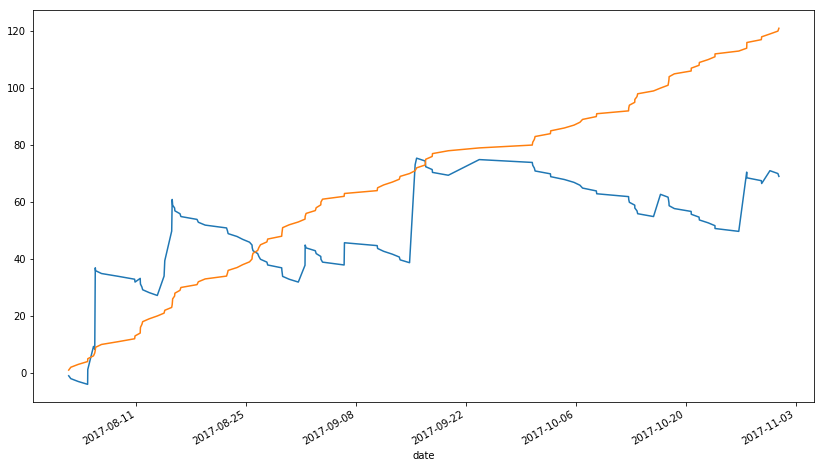

In [446]:
import matplotlib
%matplotlib inline
bets['stash'].plot()
bets['bets'].plot(figsize=(14,8))

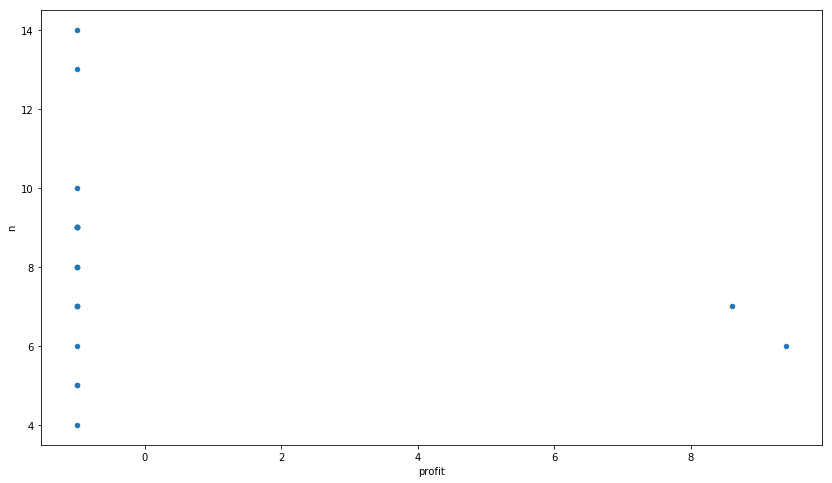

In [216]:
bets.plot.scatter(x='profit', y='n', figsize=(14,8))

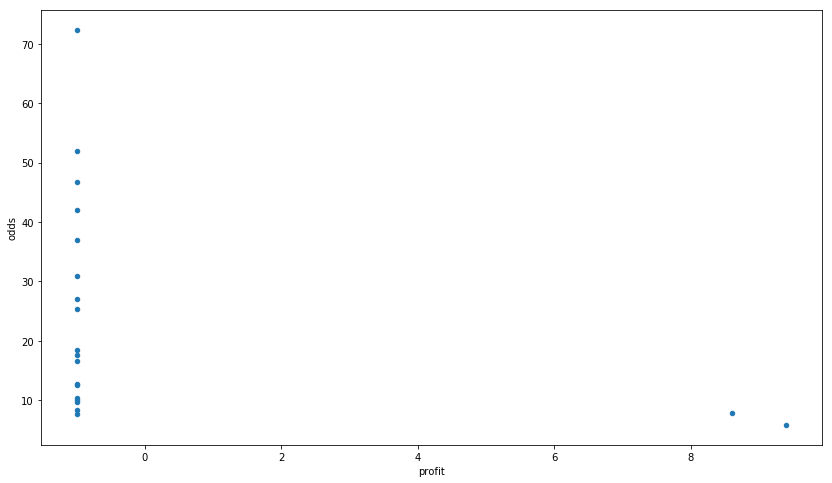

In [217]:
bets.plot.scatter(x='profit', y='odds', figsize=(14,8))

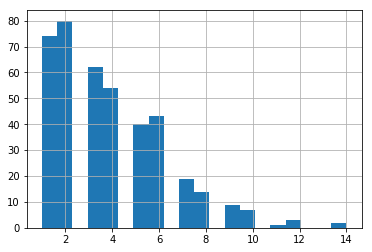

In [133]:
bets['pos'].hist(bins=20)

In [447]:
bets[0:100]

,id,cat,target,n,date,bet,pos,odds,pred_1,pred_2,pred_3,num,profit,bets,stash
date,,,,,,,,,,,,,,,
2017-08-02 10:40:00,3663,INTERNATIONALE_AUTOSTART,-1.325650e+01,8,2017-08-02 10:40:00,1.0,2.0,21.9,4.824414e-03,1.308747e-02,5.546670e-03,4,-1.0,1.0,-1.0
2017-08-02 17:05:00,3662,AUTOSTART,-6.074478e-01,15,2017-08-02 17:05:00,1.0,4.0,10.5,4.695398e-03,1.071534e-03,1.959800e-01,5,-1.0,2.0,-2.0
2017-08-03 15:43:00,3708,AUTOSTART,-5.644326e-02,9,2017-08-03 15:43:00,1.0,5.0,24.7,5.056911e-07,2.010808e-03,9.953318e-01,4,-1.0,3.0,-3.0
2017-08-04 20:28:00,3768,AUTOSTART,-1.752629e-01,14,2017-08-04 20:28:00,1.0,11.0,4.3,5.076720e-02,8.079391e-04,9.353628e-01,3,-1.0,4.0,-4.0
2017-08-04 20:55:00,3769,AUTOSTART,-8.667715e-01,13,2017-08-04 20:55:00,1.0,1.0,5.3,5.162846e-03,8.868603e-02,1.774933e-01,8,5.2,5.0,1.2
2017-08-05 14:20:00,3791,AUTOSTART,-1.151693e+00,9,2017-08-05 14:20:00,1.0,1.0,7.1,9.789200e-04,1.756971e-01,2.067349e-01,2,8.1,6.0,9.3
2017-08-05 18:15:00,3803,AUTOSTART,-1.520243e-01,11,2017-08-05 18:15:00,1.0,6.0,14.6,2.072282e-03,1.203757e-01,4.060431e-01,7,-1.0,7.0,8.3
2017-08-05 19:52:00,3806,NATIONALE_AUTOSTART,-1.833599e-01,10,2017-08-05 19:52:00,1.0,1.0,20.3,1.931705e-02,1.246282e-01,3.046790e-01,8,28.6,8.0,36.9
2017-08-05 20:47:00,3808,APPRENTIS_LADS_JOCKEYS_AUTOSTART,-8.830138e-02,9,2017-08-05 20:47:00,1.0,5.0,12.3,1.605392e-03,3.570736e-04,8.711424e-01,5,-1.0,9.0,35.9


cat     AMATEURS_AUTOSTART  APPRENTIS_LADS_JOCKEYS_AUTOSTART  AUTOSTART  \
profit            2.471429                              -1.0   0.167123   
profit            7.000000                               5.0  73.000000   

cat     A_RECLAMER_AUTOSTART  EUROPEENNE_AUTOSTART  GROUPE_I  GROUPE_II  \
profit                  -1.0                  -1.0      -1.0       -1.0   
profit                   1.0                   2.0       1.0        1.0   

cat     GROUPE_III  INTERNATIONALE_AUTOSTART  NATIONALE_AUTOSTART  
profit        -1.0                  1.384615             1.911765  
profit         1.0                 13.000000            17.000000  


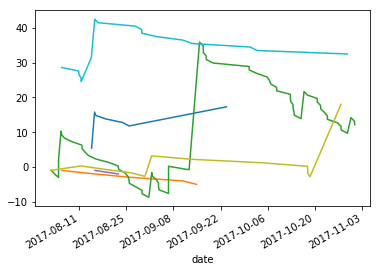

In [448]:
bets_cat = bets.groupby('cat')

print( pd.DataFrame([bets_cat['profit'].mean(), bets_cat['profit'].count()]) )

for cat, b in bets_cat:
    b['profit'].cumsum().plot(label=cat)
